In [1]:
!pip install opencv-python

In [2]:
import tensorflow as tf
import os

/Users/anikait/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')


[]

In [5]:
import cv2
import imghdr

In [6]:
data_dir = 'Data/Images' 


In [7]:
image_exts = ['jpeg','jpg', 'bmp', 'png']


In [8]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

In [9]:
import numpy as np
from matplotlib import pyplot as plt

In [51]:
data = tf.keras.utils.image_dataset_from_directory(directory = data_dir ,label_mode = 'categorical',color_mode = "grayscale",image_size =(63, 1197),batch_size=32 )

Found 634 files belonging to 4 classes.


In [52]:
iterator = data.as_numpy_iterator()


In [53]:
batch = iterator.next()

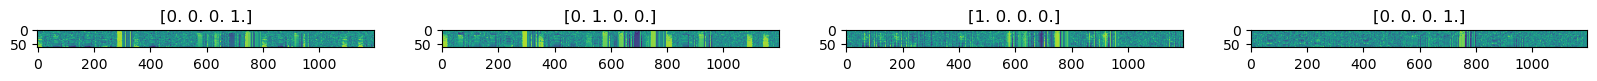

In [54]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [55]:
data = data.map(lambda x,y: (x/255, y))


In [56]:
data.as_numpy_iterator().next()

(array([[[[0.58431375],
          [0.56078434],
          [0.20392157],
          ...,
          [0.6039216 ],
          [0.3137255 ],
          [0.20392157]],
 
         [[0.37254903],
          [0.39607844],
          [0.08235294],
          ...,
          [0.1764706 ],
          [0.05490196],
          [0.44705883]],
 
         [[0.92156863],
          [0.08627451],
          [0.4392157 ],
          ...,
          [0.3882353 ],
          [0.17254902],
          [0.17254902]],
 
         ...,
 
         [[0.9764706 ],
          [0.09019608],
          [0.79607844],
          ...,
          [0.972549  ],
          [0.        ],
          [0.05490196]],
 
         [[0.70980394],
          [0.01960784],
          [0.5764706 ],
          ...,
          [0.62352943],
          [0.31764707],
          [0.25490198]],
 
         [[0.9254902 ],
          [0.09411765],
          [0.69803923],
          ...,
          [0.05490196],
          [0.06666667],
          [0.04313726]]],
 
 
        [

In [57]:
train_size = int(len(data)*.7)
val_size = int(len(data)* 2)
test_size = int(len(data)*1)

In [58]:
train_size


14

In [59]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [60]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 63, 1197, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout , BatchNormalization , Activation, AveragePooling2D, GlobalAveragePooling2D

In [71]:
model = Sequential()

In [72]:
model.add(Conv2D(32, (5, 5), strides = (1, 1), name = 'conv0', input_shape = (63, 1197, 1)))

model.add(BatchNormalization(axis = 3, name = 'bn0'))
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2), name='max_pool'))
model.add(Conv2D(64, (3, 3), strides = (1,1), name="conv1"))
model.add(Activation('relu'))
model.add(AveragePooling2D((3, 3), name='avg_pool'))

model.add(GlobalAveragePooling2D())
model.add(Dense(300, activation="relu", name='rl'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax', name='sm'))

In [73]:
model.compile('adam', loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])


In [74]:
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv0 (Conv2D)              (None, 59, 1193, 32)      832       
                                                                 
 bn0 (BatchNormalization)    (None, 59, 1193, 32)      128       
                                                                 
 activation_10 (Activation)  (None, 59, 1193, 32)      0         
                                                                 
 max_pool (MaxPooling2D)     (None, 29, 596, 32)       0         
                                                                 
 conv1 (Conv2D)              (None, 27, 594, 64)       18496     
                                                                 
 activation_11 (Activation)  (None, 27, 594, 64)       0         
                                                                 
 avg_pool (AveragePooling2D)  (None, 9, 198, 64)      

In [75]:
for layer in model.layers:
    print(layer.output_shape)

(None, 59, 1193, 32)
(None, 59, 1193, 32)
(None, 59, 1193, 32)
(None, 29, 596, 32)
(None, 27, 594, 64)
(None, 27, 594, 64)
(None, 9, 198, 64)
(None, 64)
(None, 300)
(None, 300)
(None, 4)


In [76]:
logdir='logs'


In [77]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')


In [78]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/20
14/14 [==============================] - 15s 1s/step - loss: 1.4450 - accuracy: 0.2299 - val_loss: 1.3862 - val_accuracy: 0.2527
Epoch 2/20
14/14 [==============================] - 15s 1s/step - loss: 1.3986 - accuracy: 0.2656 - val_loss: 1.3876 - val_accuracy: 0.2258
Epoch 3/20
14/14 [==============================] - 16s 1s/step - loss: 1.3892 - accuracy: 0.2567 - val_loss: 1.3874 - val_accuracy: 0.2581
Epoch 4/20
14/14 [==============================] - 16s 1s/step - loss: 1.3885 - accuracy: 0.2433 - val_loss: 1.3881 - val_accuracy: 0.2258
Epoch 5/20
14/14 [==============================] - 16s 1s/step - loss: 1.3923 - accuracy: 0.2388 - val_loss: 1.3872 - val_accuracy: 0.2419
Epoch 6/20
14/14 [==============================] - 16s 1s/step - loss: 1.3847 - accuracy: 0.2701 - val_loss: 1.3883 - val_accuracy: 0.2204
Epoch 7/20
14/14 [==============================] - 16s 1s/step - loss: 1.3875 - accuracy: 0.2679 - val_loss: 1.3865 - val_accuracy: 0.2796
Epoch 8/20
14/14 [==

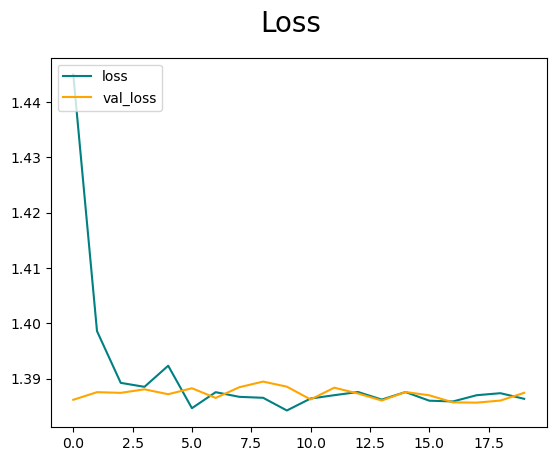

In [79]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

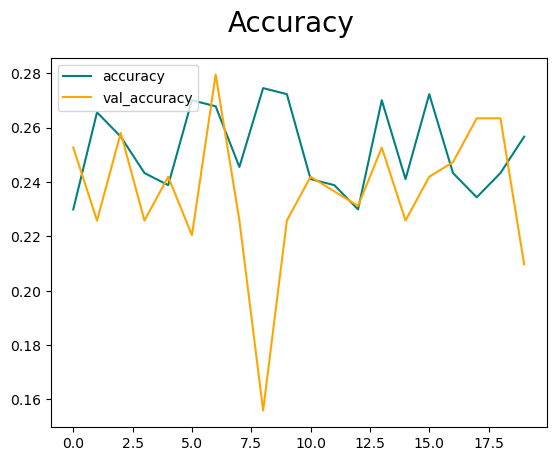

In [80]:

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()


In [81]:
from tensorflow.keras.metrics import Precision, Recall,CategoricalAccuracy


In [82]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator(): 
    print(len(batch[1]))
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [ ]:
print(pre.result(), re.result(), acc.result())


tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


In [ ]:
import cv2
from tensorflow.keras.preprocessing import image


Image Dimensions : (63, 1197, 1)


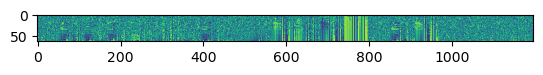

In [ ]:
img = cv2.imread('116.png',0)
plt.imshow(img)
img = np.expand_dims(img, axis=2)
print('Image Dimensions :', img.shape)
plt.show()

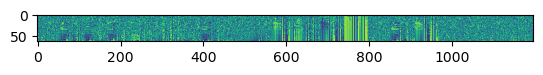

In [ ]:
resize = tf.image.resize(img, (63,1197))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 81ms/step


In [ ]:
yhat


array([[0.24929808, 0.25589466, 0.24715929, 0.24764799]], dtype=float32)

In [59]:
if np.argmax(yhat) == 0: 
    print(f'Predicted class is GNAW')
elif np.argmax(yhat) == 1:
    print(f'Predicted class is KNEW')
elif np.argmax(yhat) == 2:
    print(f'Predicted class is PAT')
elif np.argmax(yhat) == 3:
    print(f'Predicted class is POT')
else:
    print(f'Error')
    

    


Predicted class is POT
